In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import copy

%matplotlib inline

### <p style="text-align: center; color: green;">Motion Estimation Mesh based</p>  

#### We are going to show the motion estimation between two images with the mesh based method seen in class that derives from the node based one.

Let's recreate the Image class.

In [2]:
class Image:

    def __init__(self, pathImg):
        self.img = cv2.imread(pathImg)
        self.grayImage = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        self.height, self.width = self.grayImage.shape[:2]

Let's load the two images

In [3]:
img1 = Image('1.png')
img2 = Image('2.png')

Defining constants :

In [4]:
BLOCK_LEN = img1.grayImage.shape[0] // 4
STEP = 4

Same methods as in node based.

In [5]:
# Define the colors of the rectangles
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'white']

# function returning the coordinates of the blocks from the image
def getBlocksCoordinates(img):
    blocksCoordinates = []
    len = img.shape[0] // BLOCK_LEN
    for i in range(len):
        for j in range(len):
            blocksCoordinates.append([[i*BLOCK_LEN, j*BLOCK_LEN], [(i+1)*BLOCK_LEN, j*BLOCK_LEN], [(i+1)*BLOCK_LEN, (j+1)*BLOCK_LEN], [i*BLOCK_LEN, (j+1)*BLOCK_LEN]])
    return blocksCoordinates

# function getting the all the coordinates inside of a block knowing its up left corner coordinates and its length
def getBlockPixels(nodes):
    array = []
    for i in range(nodes[0][0], nodes[2][0], STEP):
        for j in range(nodes[0][1], nodes[2][1], STEP):
            array.append([i, j])
    return array



Let's create a dictionnary that we will use to iterate over the nodes and that will tell us which blocks it is linked to.

In [6]:
'''
    Function returning a dictionnary with
        node coordinates as keys
        list of the 4 indexes corresponding to the 4 blocks around the node
'''
def getNodesDict(img):
    nodesDict = {}
    width = img.shape[0] // BLOCK_LEN
    height = img.shape[1] // BLOCK_LEN
    for i in range(0, img.shape[0] + 1, BLOCK_LEN):
        for j in range(0, img.shape[1] + 1, BLOCK_LEN):
            indexes = []
            if i + BLOCK_LEN <= img.shape[0] and j + BLOCK_LEN <= img.shape[1]:
                indexes.append((i // BLOCK_LEN) * height + j // BLOCK_LEN)
            if i - BLOCK_LEN >= 0 and j - BLOCK_LEN >= 0:
                indexes.append((i // BLOCK_LEN - 1) * height + j // BLOCK_LEN - 1)
            if i - BLOCK_LEN >= 0 and j + BLOCK_LEN <= img.shape[1]:
                indexes.append((i // BLOCK_LEN - 1) * height + j // BLOCK_LEN)
            if j - BLOCK_LEN >= 0 and i + BLOCK_LEN <= img.shape[0]:
                indexes.append((i // BLOCK_LEN) * height + j // BLOCK_LEN - 1)

            nodesDict[(i, j)] = indexes
    return nodesDict

Now we rewrite the code defined in node based that will handle the computing of the energy for the blocks :

In [8]:
def getInterpolation(corners):
    list_x = [corners[0][0], corners[1][0], corners[2][0], corners[3][0]]
    list_y = [corners[0][1], corners[1][1], corners[2][1], corners[3][1]]

    xmax, xmin, ymax, ymin = max(list_x), min(list_x), max(list_y), min(list_y)
    constant = (xmax-xmin)*(ymax-ymin)

    phi1 = lambda x,y : (xmax-x)*(ymax-y)/constant
    phi2 = lambda x,y : (x-xmin)*(ymax-y)/constant
    phi3 = lambda x,y : (x-xmin)*(y-ymin)/constant
    phi4 = lambda x,y : (xmax-x)*(y-ymin)/constant

    return phi1, phi2, phi3, phi4

def getDisplacement(corners, vectors):
    phi1, phi2, phi3, phi4 = getInterpolation(corners)
    sum = lambda x,y : phi1(x,y) * vectors[0] + phi2(x,y) * vectors[1] + phi3(x,y) * vectors[2] + phi4(x,y) * vectors[3]
    return sum

# function getting the intensity of a point in an image
def getIntensity(img, coordinate):
    return img[int(coordinate[0]), int(coordinate[1])]

# function computing the sum of quadratic displacement in a node between two images
def computeEnergyBlock(img1, img2, block, d):
    EDFD = 0
    for coordinate in getBlockPixels(block):
        newCoordinate = coordinate + d(coordinate[0], coordinate[1])

        newCoordinate[0] = max(0, min(int(newCoordinate[0]), img1.shape[0]-1))
        newCoordinate[1] = max(0, min(int(newCoordinate[1]), img1.shape[1]-1))

        I2 = getIntensity(img2, newCoordinate)
        I1 = getIntensity(img1, coordinate)
        if I2 < I1:
            EDFD += (I1 - I2) ** 2
        else:
            EDFD += (I2 - I1) ** 2
    return EDFD

We will just have to rewrite `getNodesDisplacement` a bit, and add a method to link the nodes we are iterating over with the nodes inside the circling blocks :

In [48]:
# Method to update the nodes contained in blockVectors associated with indNode with the new value
def changeBlockNodeValue(indNode, blockVectors, idxsBlocks, value, axis, img1):
    copyBlockVectors = blockVectors.copy()
    len = img1.shape[0] // BLOCK_LEN
    for idxBlock in idxsBlocks:
        if idxBlock == indNode - idxBlock // len:
            copyBlockVectors[idxBlock][0][axis] += value
        if idxBlock == indNode - idxBlock // len - 1:
            copyBlockVectors[idxBlock][3][axis] += value
        if idxBlock == indNode - idxBlock // len - len - 1:
            copyBlockVectors[idxBlock][1][axis] += value
        if idxBlock == indNode - idxBlock // len - len - 2:
            copyBlockVectors[idxBlock][2][axis] += value
    return copyBlockVectors


# Function iterating through all nodes of an image,
# computing the gradient descent of each node and returning a list of all the vectors
def getNodesDisplacement(img1, img2, learningRate=1e-4, nbEpochs=5, h=2):
    blocks = getBlocksCoordinates(img1)
    nodesDict = getNodesDict(img1)
    nodes = list(nodesDict.keys())

    blockVectors = np.zeros((len(blocks), 4, 2))
    
    for epoch in range(nbEpochs):
        print("Epoch:", epoch + 1)
        for indNode, node in enumerate(nodes):
            energy = 0
            for idxBlock in nodesDict[node]:
                blockVector = blockVectors[idxBlock]
                block = blocks[idxBlock]

                d = getDisplacement(block, blockVector)
                energy += computeEnergyBlock(img1, img2, block, d)
            
            tmp_blockVectors = copy.deepcopy(blockVectors)
            for i in range(2):
                copy_tmp_blockVectors = changeBlockNodeValue(indNode, tmp_blockVectors, nodesDict[node], h, i, img1)
                newEnergy = 0
                for idxBlock in nodesDict[node]:
                    copy_tmp_blockVector = copy_tmp_blockVectors[idxBlock].copy()
                    copy_tmp_block = blocks[idxBlock]

                    d = getDisplacement(copy_tmp_block, copy_tmp_blockVector)
                    newEnergy += computeEnergyBlock(img1, img2, copy_tmp_block, d)
                blockVectors = changeBlockNodeValue(indNode, blockVectors, nodesDict[node], -learningRate * (newEnergy - energy) / h, i, img1)  
    return blocks + blockVectors

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


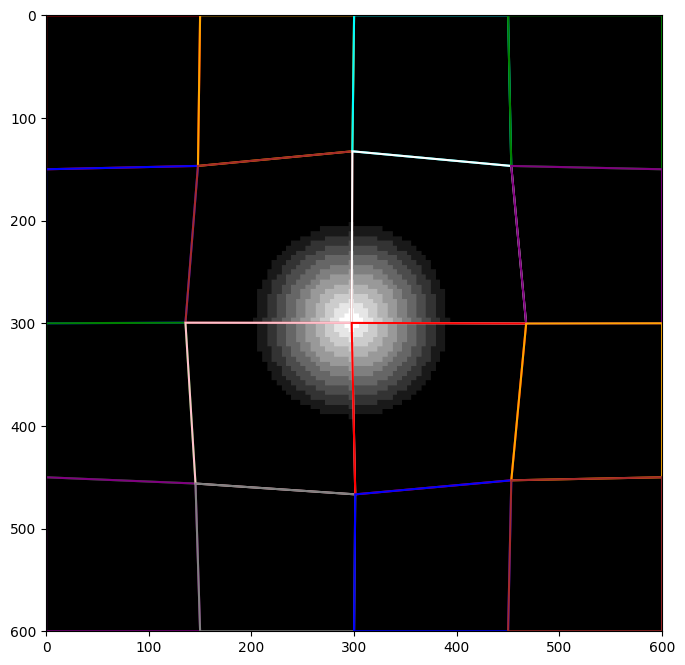

In [49]:
allNodes = getNodesDisplacement(img1.grayImage, img2.grayImage)

# Create a figure and axis object
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img1.grayImage, cmap='gray')

# Plot the polygons
for i in range(len(allNodes)):
    node = plt.Polygon(allNodes[i], fill=False, edgecolor=colors[i % len(colors)], linewidth=1.5)
    ax.add_patch(node)

# Set the limits of the plot
ax.set_xlim(0, img1.width)
ax.set_ylim(img1.height, 0)

plt.show()

Now we can clearly see that the center of the first image is being enlarged when going to the second one. Now each node is attached to their respective blocks and are moving accordingly to the position where the blocks have the minimum energy.